# Blockage Deficit Models

**The blockage deficit models compute the blockage effects caused by a single wind turbine.**

Their structure are quite similar to the [Wake Deficit Models](WakeDeficitModels.ipynb). They model upstream blockage effects (wind speed reduction) and in addition, some models also models downstream speed-up effects. There are several blockage models available, which include:

- [SelfSimilarityDeficit](#SelfSimilarityDeficit)
- [SelfSimilarityDeficit2020](#SelfSimilarityDeficit2020)
- [FugaDeficit](#FugaDeficit)
- [VortexCylinder](#VortexCylinder)
- [VortexDipole](#VortexDipole)
- [RankineHalfBody](#RankineHalfBody)
- [HybridInduction](#HybridInduction)
- [Rathmann](#Rathmann)

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# import and setup site and windTurbines
import py_wake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

In [7]:
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot
from py_wake.wind_farm_models import All2AllIterative

#turbine diameter
D = 80

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=70),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), V80(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_deficit_map(model, cmap='Blues', levels=np.linspace(0, 10, 55)):
    fm = get_flow_map(model)
    fm.plot(fm.ws - fm.WS_eff, clabel='Deficit [m/s]', levels=levels, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
               xlim=[fm.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis='auto')

def plot_blockage_deficit_map(model):
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    cmap = np.r_[cm.Reds_r(np.linspace(-0,1,127)),[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap), levels=np.linspace(-3.5,3.5,113))

### SelfSimilarityDeficit
Simple induction model, described in [N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016](https://onlinelibrary.wiley.com/doi/full/10.1002/we.2137)

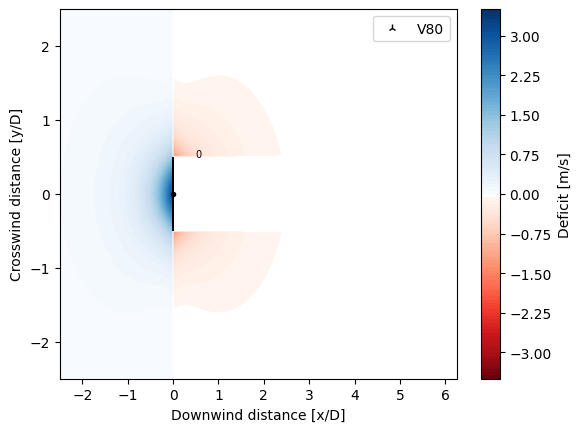

In [8]:
from py_wake.deficit_models import SelfSimilarityDeficit
plot_blockage_deficit_map(SelfSimilarityDeficit())

### SelfSimilarityDeficit2020

This is an updated version of [N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016](https://onlinelibrary.wiley.com/doi/full/10.1002/we.2137). The new features are found in the radial and axial functions:

1. Radially Eq. (13) is replaced by a linear fit, which ensures the induction half width, `r12`, to continue to diminish approaching the rotor. This avoids unphysically large lateral induction tails, which could negatively influence wind farm simulations.
2. The value of gamma in Eq. (8) is revisited. Now gamma is a function of CT and axial coordinate to force the axial induction to match the simulated results more closely. The fit is valid over a larger range of thrust coefficients and the results of the constantly loaded rotor are excluded in the fit.

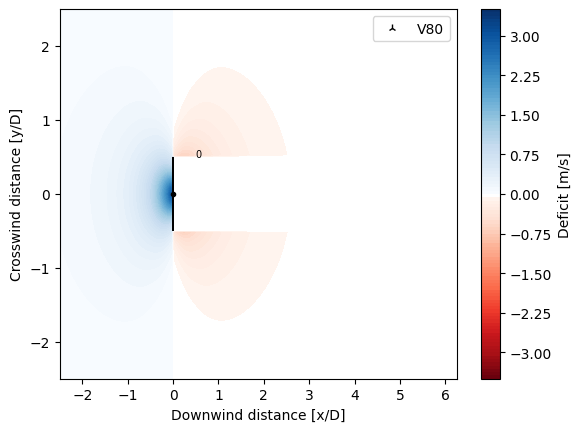

In [9]:
from py_wake.deficit_models import SelfSimilarityDeficit2020
plot_blockage_deficit_map(SelfSimilarityDeficit2020())

### FugaDeficit

The FugaDeficit model calculates the wake deficit based on a set op look-up tables computed by a linearized RANS solver. The look-up tables be created in advance using the [Fuga GUI](https://orbit.dtu.dk/en/publications/developments-of-the-offshore-wind-turbine-wake-model-fuga).

The FugaDeficit models the near wake, far wake and blockage deficit effects.

Note, the present look-up table generator introduces some unphysical wriggles in the blockage deficit/speed-up.

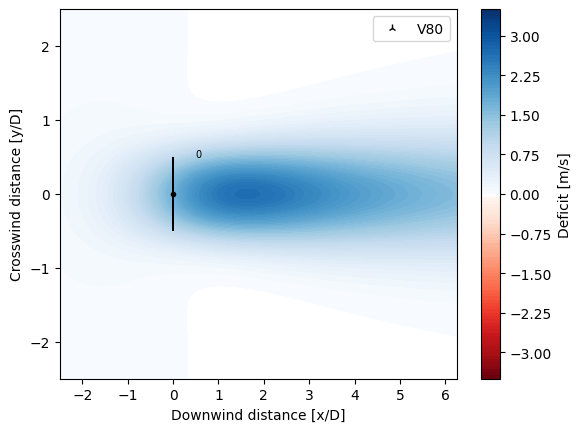

In [10]:
from py_wake.deficit_models import FugaDeficit
plot_blockage_deficit_map(FugaDeficit())

### VortexCylinder

Induced velocity from a semi-infinite cylinder of tangential vorticity, extending along the z axis.

This model is an adapted version of the one published by Emmanuel Branlard at https://github.com/ebranlard/wiz/blob/master/wiz/VortexCylinder.py

References:

- E. Branlard, M. Gaunaa, Cylindrical vortex wake model: right cylinder, Wind Energy, 2014, https://onlinelibrary.wiley.com/doi/full/10.1002/we.1800
- E. Branlard, Wind Turbine Aerodynamics and Vorticity Based Method, Springer, 2017
- E. Branlard, A. Meyer Forsting, Using a cylindrical vortex model to assess the induction zone in front of aligned and yawed rotors, in Proceedings of EWEA Offshore Conference, 2015, https://orbit.dtu.dk/en/publications/using-a-cylindrical-vortex-model-to-assess-the-induction-zone-inf

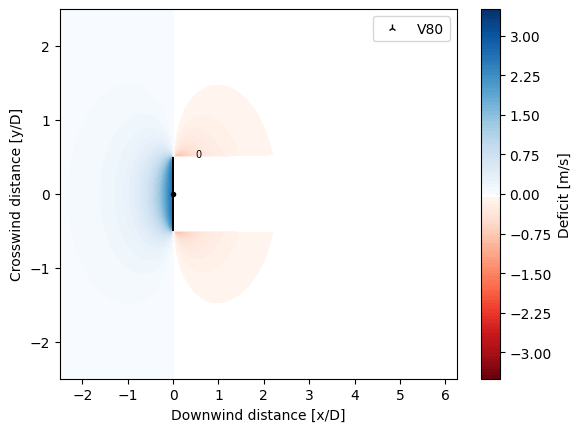

In [11]:
from py_wake.deficit_models import VortexCylinder
plot_blockage_deficit_map(VortexCylinder())

### VortexDipole

The vorticity originating from a wind turbine can be represented by a vortex dipole line (see Appendix B in [2]). The induction estimated by such a representation is very similar to the results given by the more complex vortex cylinder model in the far-field r/R > 6 [1,2]. The implementation follows the relationships given in [1,2]. This model is an adapted version of the one published by Emmanuel Branlard: https://github.com/ebranlard/wiz/blob/master/wiz/VortexDoublet.py

References:
- [1] Emmanuel Branlard et al 2020 J. Phys.: Conf. Ser. 1618 062036
- [2] Branlard, E, Meyer Forsting, AR. Wind Energy. 2020; 23: 2068– 2086.  https://doi.org/10.1002/we.2546

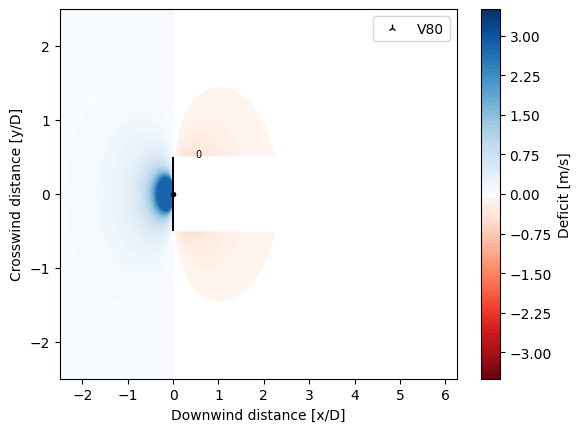

In [12]:
from py_wake.deficit_models import VortexDipole
plot_blockage_deficit_map(VortexDipole())

### RankineHalfBody

A simple induction model using a Rankine Half Body to represent the induction introduced by a wind turbine. The source strength is determined enforcing 1D momentum balance at the rotor disc.

References:

- B Gribben, G Hawkes - A potential flow model for wind turbine induction and wind farm blockage - Technical Paper, Frazer-Nash Consultancy, 2019

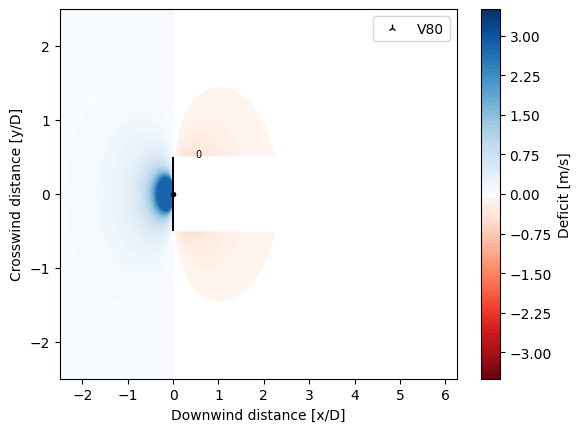

In [13]:
from py_wake.deficit_models import RankineHalfBody
plot_blockage_deficit_map(RankineHalfBody())

### HybridInduction
The idea behind this model originates from [2,3], which advocates to combine near-rotor and farfield approximations of a rotor's induced velocities. Whereas in [1,2] the motivation is to reduce the computational effort, here the already very fast self-similar model [1] is combined with the vortex dipole approximation in the far-field, as the self-similar one is optimized for the near-field (r/R > 6, x/R < 1) and misses the acceleration around the wake for x/R > 0. The combination of both allows capturing the redistribution of energy by blockage. Location at which to switch from near-rotor to far-field can be altered though by setting switch_radius.

References:
1. N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016
2. Emmanuel Branlard et al 2020 J. Phys.: Conf. Ser. 1618 062036
3. Branlard, E, Meyer Forsting, AR. Wind Energy. 2020; 23: 2068– 2086. https://doi.org/10.1002/we.2546

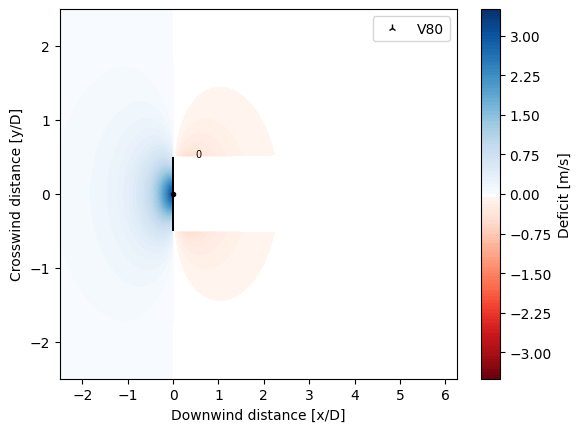

In [14]:
from py_wake.deficit_models import HybridInduction
plot_blockage_deficit_map(HybridInduction())

### Rathmann

Ole Sten Rathmann (DTU) developed in 2020 an approximation to the vortex cylinder solution (E. Branlard and M. Gaunaa, 2014). In speed it is comparable to the vortex dipole method, whilst giving a flow-field nearly identical to the vortex cylinder model for x/R < -1. Its centreline deficit is identical to the vortex cylinder model, whilst using a radial shape function that depends on the opening of the vortex cylinder seen from a point upstream. To simulate the speed-up downstream the deficit is mirrored in the rotor plane with a sign change.

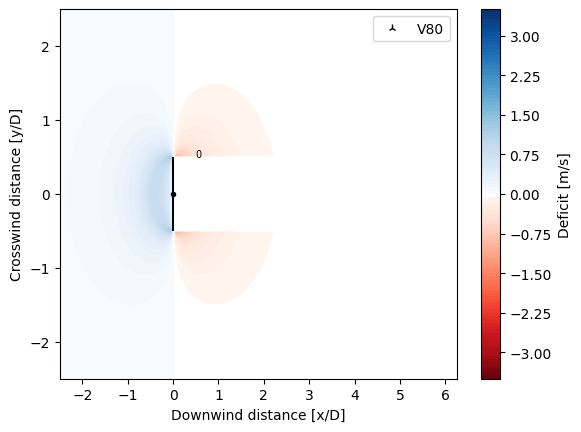

In [15]:
from py_wake.deficit_models import Rathmann
plot_blockage_deficit_map(Rathmann())

### Comparing different blockage deficit models

In [16]:
from py_wake.utils.model_utils import get_models
from py_wake.deficit_models.deficit_model import BlockageDeficitModel

blockage_deficitModels = get_models(BlockageDeficitModel, exclude_None=True)
for deficitModel in blockage_deficitModels:
    print (deficitModel.__name__)

FugaDeficit
FugaMultiLUTDeficit
FugaYawDeficit
HybridInduction
SelfSimilarityDeficit2020
VortexDipole
RankineHalfBody
Rathmann
RathmannScaled
SelfSimilarityDeficit
VortexCylinder


**1) Deficit along center line**

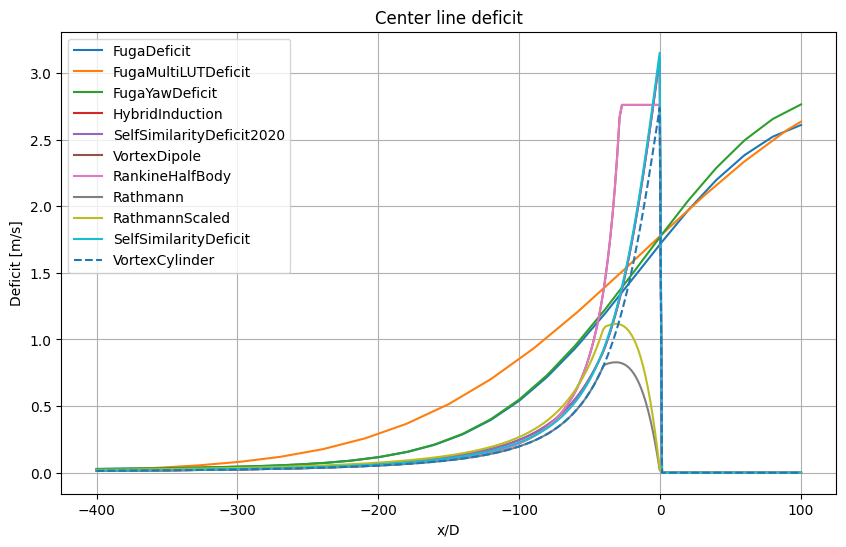

In [17]:
plt.figure(figsize=((10,6)))
for i, deficitModel in enumerate(blockage_deficitModels):
    fm = get_flow_map(deficitModel(), XYGrid(x=np.linspace(-400,100,300), y=0))
    plt.plot(fm.x, 10-fm.WS_eff.squeeze(), ('-','--')[i//10], label=deficitModel.__name__)
setup_plot(title="Center line deficit", xlabel='x/D', ylabel='Deficit [m/s]')

**2) Deficit profile 1 up- and downstream**

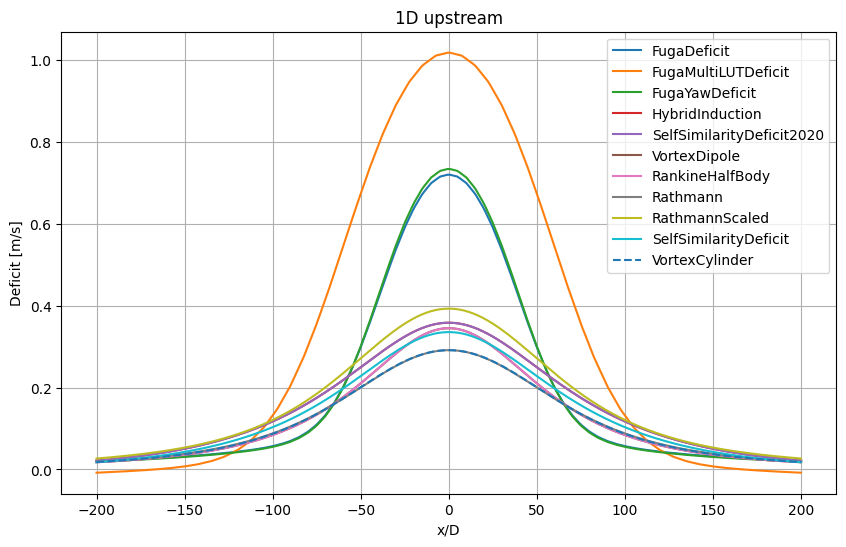

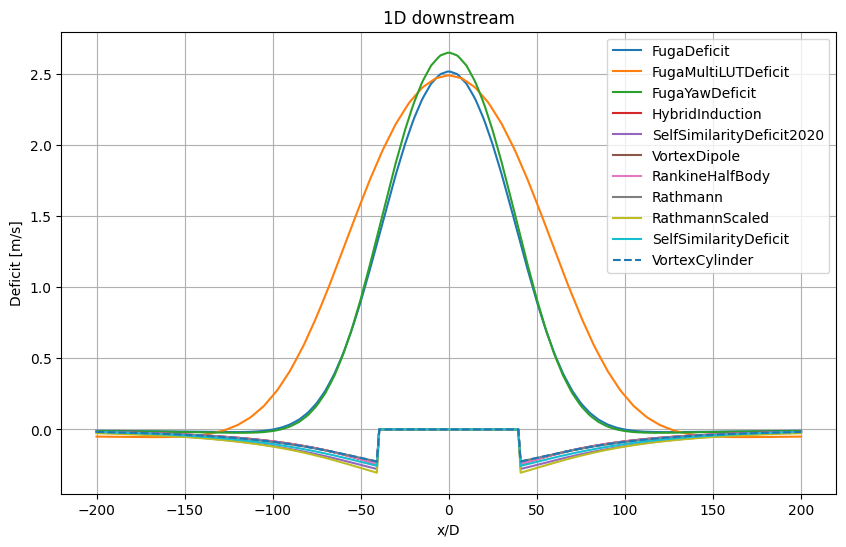

In [18]:
for d in [-1,1]:
    plt.figure(figsize=((10,6)))
    for i, deficitModel in enumerate(blockage_deficitModels):
        fm = get_flow_map(deficitModel(), XYGrid(x=d*D, y=np.linspace(-200,200,300)))
        plt.plot(fm.y, 10-fm.WS_eff.squeeze(), ('-','--')[i//10], label=deficitModel.__name__)
    setup_plot(title="%sD %sstream"%(abs(d),('down','up')[d<0]), xlabel='x/D', ylabel='Deficit [m/s]')